# Import Libraries

In [24]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from cdlib import algorithms
from IPython.display import IFrame

# Define Folder Directory for Path

In [3]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"

DATA_DIR, OUTPUTS_DIR

(PosixPath('/Users/stephenhelvig/Documents/Python Projects/20th-century/data'),
 PosixPath('/Users/stephenhelvig/Documents/Python Projects/20th-century/outputs'))

# Load Data

In [6]:
relationships_df = pd.read_csv(DATA_DIR / "20th_century_country_relationships.csv")

display(relationships_df.head())

,source,target,value
0,Austria,France,1
1,Austria,Hungary,1
2,Hungary,Russia,1
3,Germany,Russia,19
4,Germany,Ukraine,9


# Build NetworkX Object

In [7]:
G = nx.from_pandas_edgelist(
    relationships_df,
    source="source",
    target="target",
    edge_attr="value",
    create_using=nx.Graph()
)

print("nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

nodes: 56 edges: 115


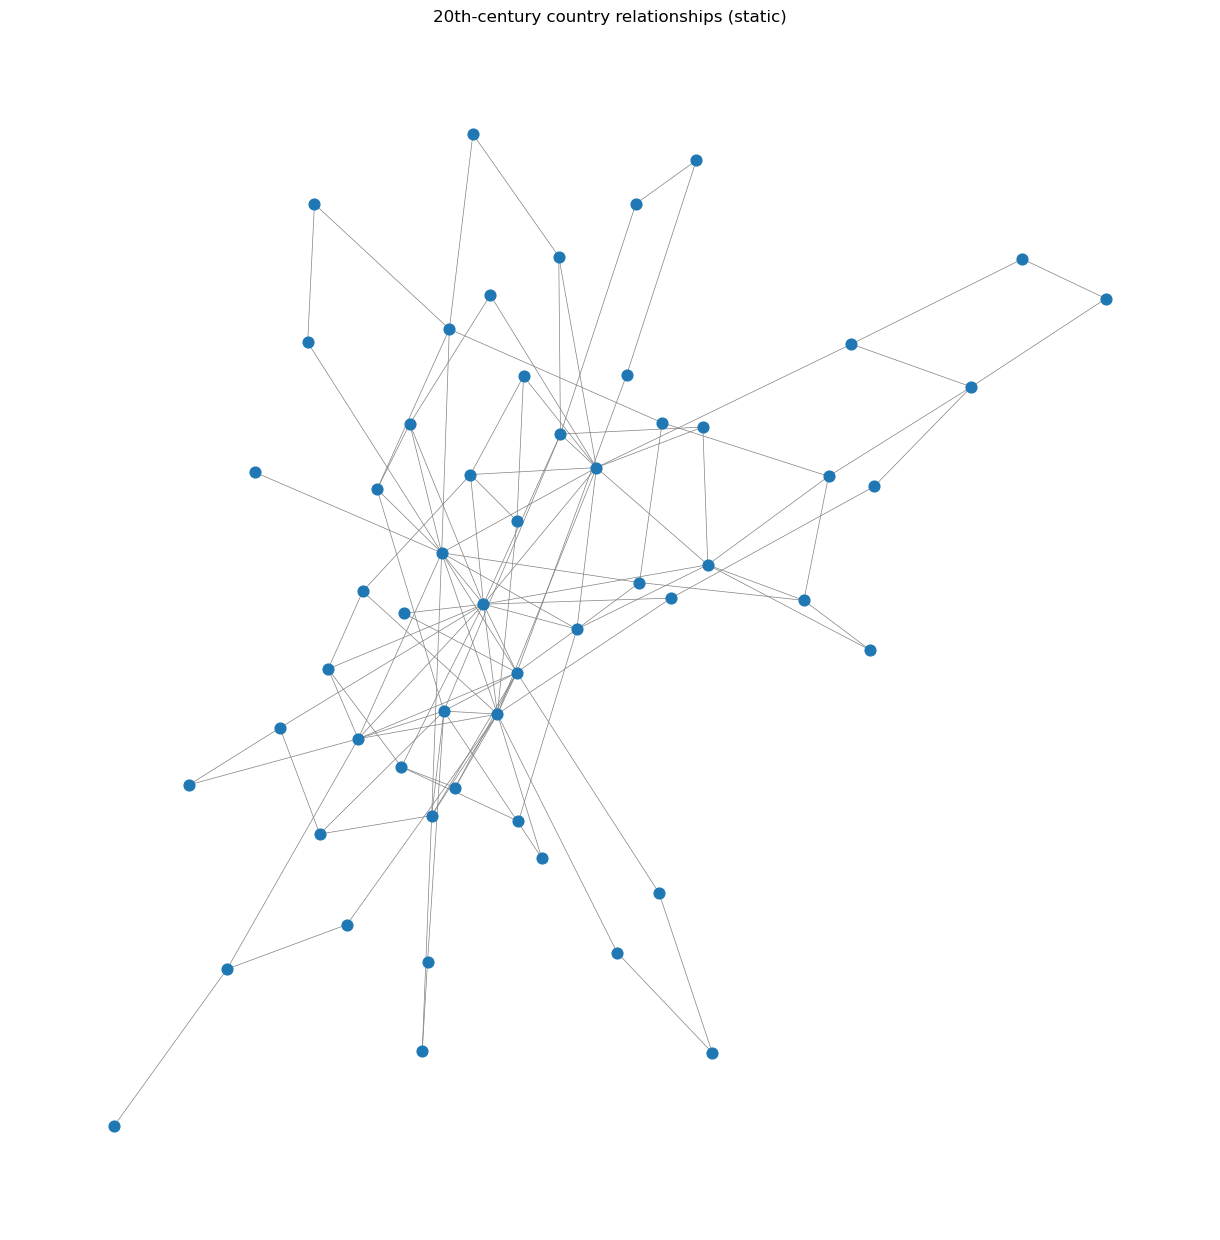

In [9]:
# create a static network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)

nx.draw(
    G,
    pos=pos,
    node_size=60,
    with_labels=False,
    edge_color="gray",
    width=0.5
)

plt.title("20th-century country relationships (static)")
plt.axis("off")
plt.show()

In [20]:
# create an interactive PyVis graph
net = Network(
    notebook=True,
    width="1100px",
    height="800px",
    bgcolor="#222222",
    font_color="white",
    cdn_resources="in_line"
)

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "size")

net.from_nx(G)
net.show_buttons(filter_=True)
net.repulsion()

# save to outputs
out_path = OUTPUTS_DIR / "countries_network.html"
net.write_html(str(out_path))

# display in notebook (relative path from /notebooks)
IFrame(src="../outputs/countries_network.html", width=1100, height=800)

In [25]:
# Apply the Leiden algorithm to detect any communities within the countries
coms = algorithms.leiden(G)
new_com = coms.to_node_community_map()
dict_com = {k: v[0] for k, v in new_com.items()}

nx.set_node_attributes(G, dict_com, "group")

com_net = Network(
    notebook=True,
    width="1100px",
    height="800px",
    bgcolor="#222222",
    font_color="white",
    cdn_resources="in_line"
)

com_net.from_nx(G)
com_net.show_buttons(filter_=True)
com_net.repulsion()

# save to outputs
out_path = OUTPUTS_DIR / "countries_communities_leiden.html"
com_net.write_html(str(out_path))

# display in notebook (relative path from /notebooks)
IFrame(src="../outputs/countries_communities_leiden.html", width=1100, height=800)

# Comments

The communities network graph makes partial sense. The largest nodes are Russia, Germany, Japan, United States, France, and United Kingdom which is expected. There are also communities grouped together based on regionality like Netherlands, Luxembourg and Belgium and Pacific countries like Japan, Phillippines, Singapore, Thailand, and Australia. But when thinking about alliances, these groupings don't always make sense (Australia grouped with Japan or Cuba grouped with United States.)

But given that the graph is mapping relationships between countries mentioned in the same sentences, the groupings are believable. The conflicts between United States and Vietnam, Cambodia, and Cuba during the Cold War and Vietnam War would explain this. 

I think it would be beneficial to further define the relationships - perhaps based on alliances - to make the network graph more clear. But, if you look at this from the perspective of how often countries would be mentioned together based on historical events, this is believable. 

# Centrality Measures and Bar Charts

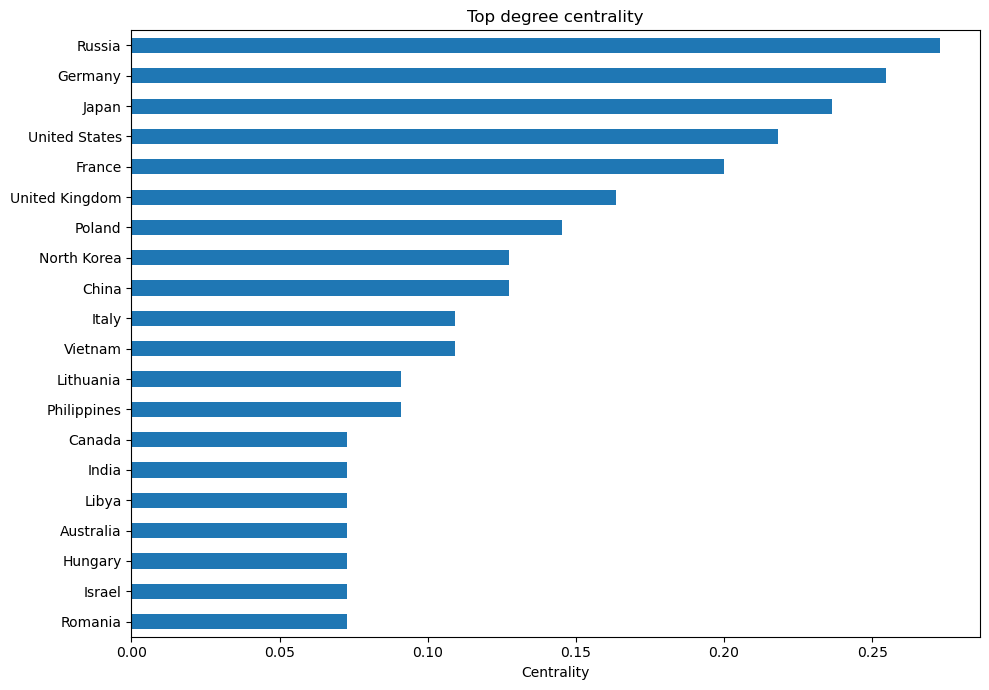

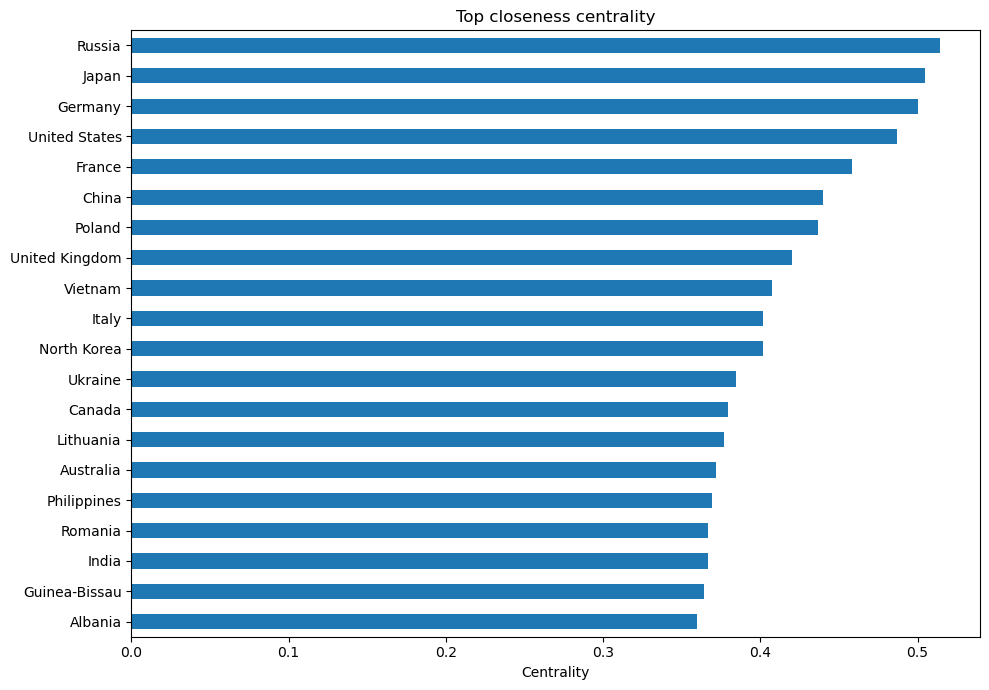

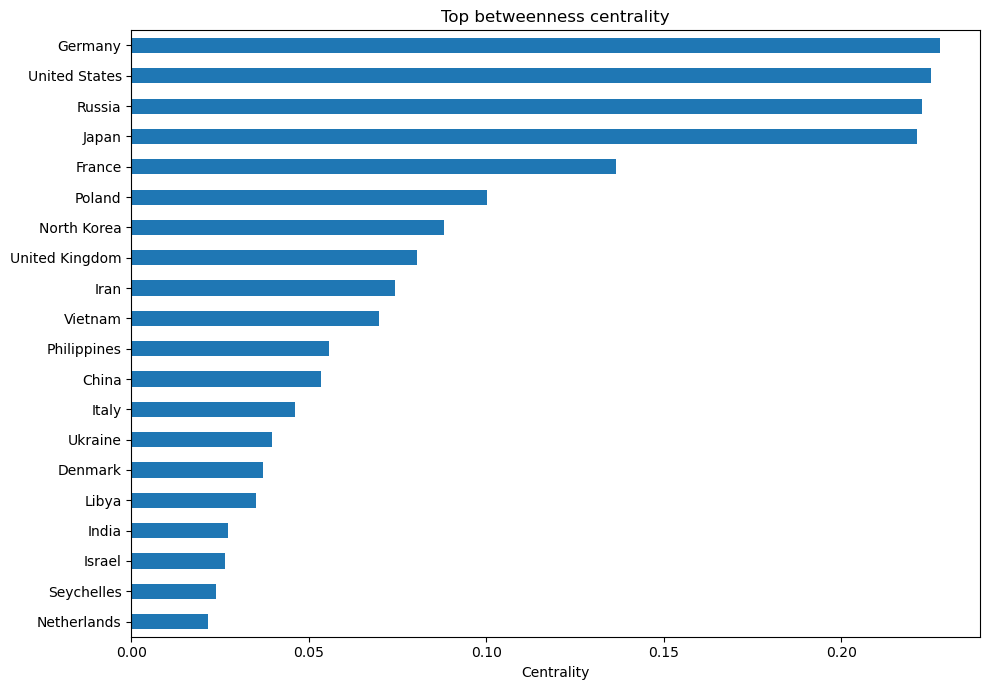

In [23]:
def plot_top_centrality(cent_dict, title, top_n=20):
    df = (
        pd.DataFrame.from_dict(cent_dict, orient="index", columns=["centrality"])
        .sort_values("centrality", ascending=False)
        .head(top_n)
        .sort_values("centrality")
    )
    ax = df.plot(kind="barh", figsize=(10, 7), legend=False)
    ax.set_title(title)
    ax.set_xlabel("Centrality")
    plt.tight_layout()
    plt.show()
    return df

deg_cent = nx.degree_centrality(G)
plot_top_centrality(deg_cent, "Top degree centrality", top_n=20);

clo_cent = nx.closeness_centrality(G)
plot_top_centrality(clo_cent, "Top closeness centrality", top_n=20);

bet_cent = nx.betweenness_centrality(G, normalized=True)
plot_top_centrality(bet_cent, "Top betweenness centrality", top_n=20);

# Comments on Centrality Charts

**Degree Centrality:** This highlights countries that have the most direct connections to other countries in the network. The countries with the most direct connections include Russia, Germany, Japan, and the United States, followed by France and the United Kingdom. This makes sense for 20th-century events. There are some countries in the top 20 that aren't exactly "global powers" like Lithunia, Libya, and the Phillipines, but that just means that these countries were mentioned in connection with events/topics enough to be included. 

**Closeness Centrality:** This measures how quickly a country can reach all others through the network (shortest paths). The top rankings are again dominated by Russia, Japan, Germany, and the United States. Closeness values are fairly high across all the top countries, suggesting that there are many nodes that connect through a few hubs. If we think of the few "major powers" as the hubs, this makes sense again. 

**Betweenness Centrality:** This measures "bridge" countries that connect parts of the network that would otherwise be less connected. Germany and the United States rank highest, followed by Russia and Japan. These countries act as connectors between different clusters, not just high-degree hubs. Some countries can be higher in degree/closeness but lower in betweenness (like China) because they are less critical as "bridges" between communities in this network.

Across all three measures, Germany, United States, Russia, and Japan are the most important nodes. This network has a small set of highly central countries that anchor and connect many of the 20th-century relationship patterns found in the data. 